## This notebook pulls data from PycityLayers, based on proximity to a selected location (my home), and selects the buildings within the radius. Then it creates a graph based on the selected buildings' centroids. This graph is later used in Agent-Based Model (ABM) developed to represent occupants presence within each building.
#### Assumptions are as follows:
1. Each Building is considered as a single node.
2. Nodes are divided into residential and non-residential.
3. Each residential node is connected to all non-residential. All Nodes are connected themselves. (Note: next step #)
4. One agent is generated and assigned per each residential building. (Note: next step #) 
5. Agents' activities are limited to presence, based on TUS profiles assigned randomly to the agents. Their profile does not change. (Note: next step #)
6. Being present in home means occupying the home. However, when not at home, agents randomly select a non-residential node to occupy.
7. Time resolution is minutes.
8. As things stand, there is no implications to occupants' being home or outside. They only replicate their assigned profile.

#### next steps 
1. Increase the resolution of occupants from one per whole building to one per unit/household (later one per person within household?)
2. Distinguish between different types of buildings. (currently: res/non-res) 
3. Imporve the connections and movement behavior (useful for transportation purposes)
4. Add other attributes to occupants (agents) (currently: only presence) (via DNAS framework)
5. Add attributes to the nodes (currently: none) (examples: envelope characteristics, equipment properties, HVAC spec. etc.) 
6. Add other behaviors based on the added occupant attributes (currently: only presence)
7. Add implications (mainly energy) of occupants' presence/absence.
8. The static schedule assigned to each agent needs to change (one solution: stochastic modeling)
9. Assigning profiles in a more robust and reliable way (one solution: census-informed assigment of profiles)

* dependencies include two classes developed, Semantic_graph and TUS_analysis


# Setup

In [1]:
from pycitylayers.client import Client
from pycitylayers.utils import PointGQL, PolygonGQL
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt
import networkx as nx

## Fetch data from PyCityLayers

In [24]:
client = Client().create(source='cerc')
coll = client.collection
print("Data collection acquired")


Fetching Metadata. Please Wait ...
Data collection acquired


In [50]:
tb=coll[6][0]
print(tb)
query_point_x,query_point_y="-73.570552324815","45.530402345761175"
query_radius=0.001
query_geometry = PointGQL().point(-73.570552324815,45.530402345761175)


query_options = {
    # 'columns': ['index', 'built_area', 'geom', 'year_built'], 
    'nrows': 10000, 
    'skiprows': 0,
    'geometry_operation': 'distance_from_point',
    'geom_distance': query_radius,
    'geometry': query_geometry,
    'crs_epsg': 4326,
}

data_lots = tb.query_simple( **query_options )
print("selecting {} buildings in {} m radius of point {},{}".format(len(data_lots),round(query_radius*111100),query_point_x,query_point_y))
data_lots.head()

---------- Table:0 ----------
Name:		building_lots 
Description:	 
Format:		CSV 

selecting 54 buildings in 111 m radius of point -73.570552324815,45.530402345761175


borough_id  building_number  built_area  dwelling_number firstletter_apt  \
0      REM21             4218         454                1               0   
1      REM21             4243        2881                1               0   
2      REM21             4264         188                2               0   
3      REM21             4235         219                3               0   
4      REM21             4263         157                2               0   

                                                geom  index  land_area  \
0  {'type': 'Polygon', 'crs': {'type': 'name', 'p...   4602         52   
1  {'type': 'Polygon', 'crs': {'type': 'name', 'p...  19021         60   
2  {'type': 'Polygon', 'crs': {'type': 'name', 'p...  19932        239   
3  {'type': 'Polygon', 'crs': {'type': 'name', 'p...  21512        284   
4  {'type': 'Polygon', 'crs': {'type': 'name', 'p...  22034        258   

   landuse_code landuse_text lastletter_apt  max_floors  municipality_code  \
0          1000     Logement              0           1                 50   
1          1000     Logement              0           1                 50   
2          1000     Logement              0           2                 50   
3          1000     Logement              0           2                 50   
4          1000     Logement              0           2                 50   

        nad83_registration             street_name  street_number      uid  \
0  9943-34-1120-6-001-0004  avenue Papineau  (MTL)           4218  5011916   
1  9943-23-1019-3-001-0006        rue Fabre  (MTL)           4243  1115361   
2  9943-23-0468-3-000-0000    rue Marquette  (MTL)           4266  1030033   
3  9943-23-5995-0-000-0000    rue Marquette  (MTL)           4235  1030537   
4  9943-24-2818-5-000-0000    rue Marquette  (MTL)           4265  1030526   

  unit_category unit_number  year_built  
0   Condominium           0        1910  
1   Condominium           0        1915  
2      Régulier           0        1900  
3      Régulier           0        1885  
4      Régulier           0        1885

## Initiating the semantic_graph class and feeding the data to it.
### Residential buildings are marked green and non-residential red.

54 buildings imported


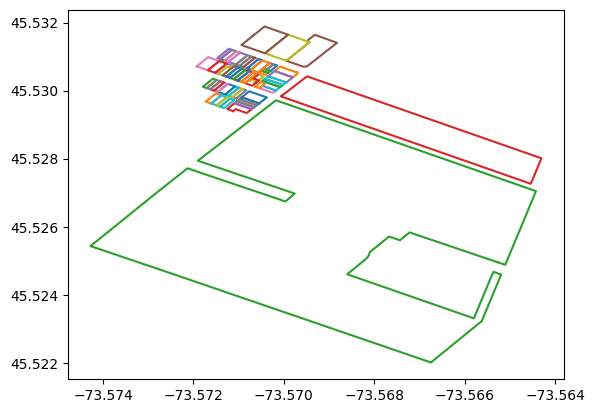

# centroids: 54
# polygons: 54
Number of nodes: 53


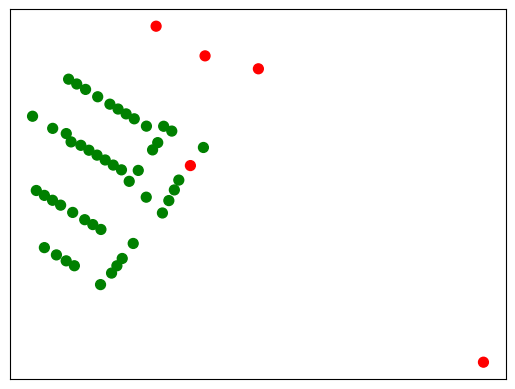

In [51]:
# import the class and create an instance of it:
import Semantic_graph as sg
Occ=sg.semantic_graph()
# feed data:
Occ.init_data(data_lots)
#create the semantic graph:
graph=Occ.create_graph(show_edges=False)

### Showing the graph with the edges

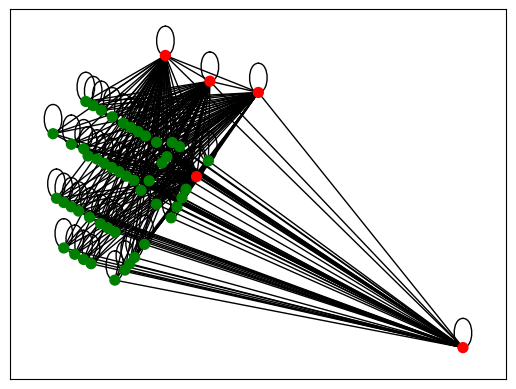

: 

In [52]:
Occ.plot_graph()

### The graph is created and can be used in the MESA space definition

## ABM setup

### Model and agents are set up such that their initial positions are their homes, which share the same ID as the agents.
### Their hourly occupancy status is determinted through randomly assigned profiles extracted from Canadian Time Use Survey.
  


In [30]:
import mesa
import random
# import TUS analysis class:
import TUS_analysis as TUS

class Agent(mesa.Agent):
    """An agent with fixed home and occupancy profile."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.home=unique_id
        self.timer=0
        self.is_home=1
        # select a random TUS ID and assign the corresponding profile
        self.PUMFID=random.choice(model.profiles.columns)
        self.profile=list(model.profiles[self.PUMFID])
        # gather a list of non-residential buildings as potential movement choices when not at home        
        self.non_res=model.non_res
    
    # action 1: leave home
    def move_out(self):
        new_position = random.choice(self.non_res)[0]
        self.model.grid.move_agent(self, new_position)
        self.is_home=0
    # action 2: go home

    def go_home(self):
        self.model.grid.move_agent(self, self.home)
        self.is_home=1

    def step(self):
        """ Define the movement of agents, based on their profiles"""
        # looking at the specific profile of the agent previously assigned, and the time (minute of the day), agent decides if moves home or not. (1 means in home)

        if list(self.profile)[self.timer % 1440]==1:
            self.go_home()
        else:
            self.move_out()

        ### Other behavior meant to add randomness in behavior - commented for now

        # if (self.timer % 24)<17:
        #     if self.pos==self.home:
        #         if random.randint(0,10)>5:
        #             self.move_out()
        #     else:
        #         if random.randint(0,10)>5:
        #             self.go_home()


        # if (self.timer % 24)>17:
        #     if self.pos==self.home:
        #         if random.randint(0,10)>5:
        #             self.move_out()
        #     else:
        #         if random.randint(0,10)>5:
        #             self.go_home()

        

        # time progresses:
        self.timer += 1

        
        # For demonstration purposes we will print the agent's unique_id, their assigned home ID (both should be the same), if at home, current location, and time

        print("Agent #" + str(self.unique_id) + ", home is:"+str(self.home)+",is home:"+str(self.is_home)+", currently at:"+str(self.pos)+", time is: "+str(self.timer))


class Model(mesa.Model):
    """A model with some number of agents."""
    # the graph that was previously created will be treated as input for the model. The number of residential nodes dictate number of agents, and non-residentials are potential nodes to be moved to when not at home.
    
    def __init__(self, Grid):
        self.Residentials = [(x,y) for x,y in Grid.nodes(data=True) if y['landuse_code']==1000]
        self.non_res=[(x,y) for x,y in Grid.nodes(data=True) if y['landuse_code']!=1000]

        self.num_agents = len(self.Residentials)
        print("# of residential buildings:",len(self.Residentials))
        self.profiles= TUS.TUS_agents().occupancy_profiles(self.num_agents)[0]
        print("Profiles extracted")

        self.grid = mesa.space.NetworkGrid(Grid)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True
        
        # Determine the residential "sub-graph"and  create agents based on it.

        Grid_residential=Grid.subgraph([x for x,y in Grid.nodes(data=True) if y['landuse_code']==1000])


        for i, node in enumerate(list(Grid_residential.nodes(data=True))):
            a = Agent(node[0], self)
            self.schedule.add(a)
            
            # Add the agent to their corresponding grid cell
            self.grid.place_agent(a,node[0])
            
        # define parameters to be reported
        self.datacollector = mesa.DataCollector(
              agent_reporters={"PUMFID":"PUMFID","profile":"profile","pos": "pos","timer":"timer","is_home":"is_home"}
        )

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

### Having set up the model and agent classes, we can run the model and feed it with previously extracted graph

In [31]:
model = Model(graph)
# run it for one full day:

for i in range(60*24):
    model.step()

# of residential buildings: 13
Number of unique people available in the dataset: 679
Profiles extracted
Agent #1002786, home is:1002786,is home:1, currently at:1002786, time is: 1
Agent #1002778, home is:1002778,is home:0, currently at:1036913, time is: 1
Agent #1036927, home is:1036927,is home:1, currently at:1036927, time is: 1
Agent #1037103, home is:1037103,is home:1, currently at:1037103, time is: 1
Agent #5033729, home is:5033729,is home:1, currently at:5033729, time is: 1
Agent #1036904, home is:1036904,is home:1, currently at:1036904, time is: 1
Agent #1002780, home is:1002780,is home:1, currently at:1002780, time is: 1
Agent #1037107, home is:1037107,is home:1, currently at:1037107, time is: 1
Agent #1109168, home is:1109168,is home:1, currently at:1109168, time is: 1
Agent #1106192, home is:1106192,is home:1, currently at:1106192, time is: 1
Agent #1037919, home is:1037919,is home:1, currently at:1037919, time is: 1
Agent #1037702, home is:1037702,is home:1, currently at:1037

## We now can extract data regarding agents behavior

In [32]:
agent_pos = model.datacollector.get_agent_vars_dataframe()
agent_pos

PUMFID                                            profile  \
Step AgentID                                                              
0    5033729   10009  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
     1002786   10004  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
     1037702   10000  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
     1036904   10007  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
     1037919   10011  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
...              ...                                                ...   
1439 1037055   10008  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
     1037107   10008  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
     1002778   10003  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
     1002780   10006  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
     1036927   10012  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                  pos  timer  is_home  
Step AgentID                           
0    5033729  5033729      0        1  
     1002786  1002786      0        1  
     1037702  1037702      0        1  
     1036904  1036904      0        1  
     1037919  1037919      0        1  
...               ...    ...      ...  
1439 1037055  1037055   1439        1  
     1037107  1037107   1439        1  
     1002778  1109175   1439        0  
     1002780  1002780   1439        1  
     1036927  1036927   1439        1  

[18720 rows x 5 columns]

## We can plot the "is_home" status and position of occupants now.

In [40]:
fig = go.Figure()
for i in agent_pos.index.unique(1):
    one_agent_pos=agent_pos.xs(i, level="AgentID")
    fig.add_trace(go.Scatter(x=model.profiles.index,y=one_agent_pos["is_home"],name=i))
fig.show()

In [47]:
fig = go.Figure()
for i in agent_pos.index.unique(1):
    one_agent_pos=agent_pos.xs(i, level="AgentID")
    fig.add_trace(go.Scatter(x=model.profiles.index,y=one_agent_pos["pos"],name=i))
fig.show()
## node names are considered as numeric (hence the million in the y-axis) - to be modified into categorical

## Comparing the TUS profiles with the assigned ones to verify correct behavior 

In [49]:
selected_PUMFID={}
for i in agent_pos.index.unique(1):
    selected_PUMFID[i]=agent_pos.xs(i, level="AgentID")["PUMFID"].unique()[0]
# selected_PUMFID
fig = go.Figure()

for i in list(selected_PUMFID.keys()):
    fig.add_trace(go.Scatter(x=model.profiles.index, y=model.profiles[selected_PUMFID[i]],
                    mode='lines',name=i))
fig.show()

## Comparison with "is_home" status plot confirms correct behavior.